In [68]:
import numpy as np 
import matplotlib.pyplot as plt

# Exercise 10

In [88]:
def calculate_sinr(gain, power, index_ue: int, index_ap: int, noise_power: float = 0.01): 
    interference = noise_power + sum(gain[index, index_ap]*p for index, p in enumerate(power) if index != index_ue)
    return gain[index_ue, index_ap]*power[index_ue]/interference

In [89]:
def power_control_dpc(gain, power, associate_ap, target_sinr=1, pmax=1, pmin=1e-3, noise_power: float = 0.01, number_of_iterations:int=50): 
    value_sinr, value_power = [], [power]
    for k in range(number_of_iterations): 
        sinr_ue = [calculate_sinr(gain=gain, power=value_power[-1], index_ue=index_ue, index_ap=associate_ap[index_ue], noise_power=noise_power) for index_ue in range(len(power))]
        power_ue = [max(min(value_power[-1][index_ue] * target_sinr/sinr_ue[index_ue], pmax), pmin) for index_ue in range(len(power))]
    
        value_sinr.append(sinr_ue)
        value_power.append(power_ue)
            
    return np.array(value_sinr), np.array(value_power)


In [90]:
sinr, power = power_control_dpc(gain=np.array([[0.1], [0.05]]), power=[1]*2, associate_ap=[0, 0], target_sinr=0.5, pmax=1, pmin=0, number_of_iterations=20)

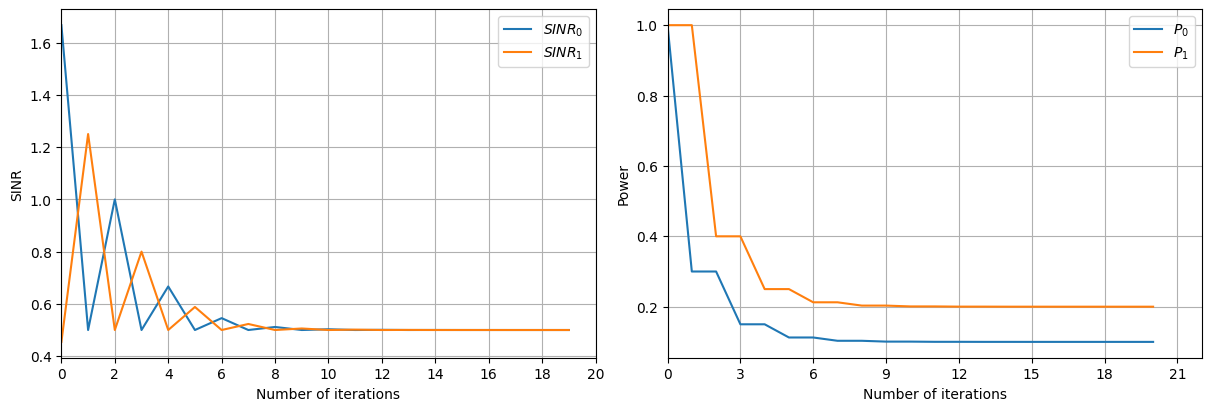

In [ ]:
fig, graf = plt.subplots(1, 2, figsize = (12, 4), constrained_layout=True)

for index_ue in range(2): 
    number_of_iterations = len(sinr[:, index_ue])
    graf[0].plot(list(range(number_of_iterations)), sinr[:, index_ue], label=f"$SINR_{index_ue}$")
graf[0].set(xlim=(0, number_of_iterations), xlabel="Number of iterations", ylabel="SINR")
graf[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
graf[0].legend()
graf[0].grid(True)

for index_ue in range(2): 
    number_of_iterations = len(power[:, index_ue])
    graf[1].plot(list(range(number_of_iterations)), power[:, index_ue], label=f"$P_{index_ue}$")
    

graf[1].set(xlim=(0, number_of_iterations+1), xlabel="Number of iterations", ylabel="Power")
graf[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
graf[1].legend()
graf[1].grid(True)

plt.show()

# Exercise 11

In [103]:
def graphic_system(position_AP, position_UE, associate_ap, size:int = 1000): 
    fig, graf = plt.subplots(figsize = (5, 4))
    graf.scatter(np.real(position_AP), np.imag(position_AP), marker='^', s=100, facecolors='none', edgecolors='blue')
    graf.scatter(np.real(position_UE), np.imag(position_UE), marker='s', s=8, facecolors='none', edgecolors='red')
    
    line_ap = np.linspace(0, size, int(np.sqrt(len(position_AP)) + 1))
    for value in line_ap: 
        graf.axvline(x=value, color='gray', linestyle='--')
        graf.axhline(y=value, color='gray', linestyle='--')
        
    for index, position in enumerate(position_UE): 
        index_ap = associate_ap[index]
        graf.plot([np.real(position), np.real(position_AP[index_ap])], [np.imag(position), np.imag(position_AP[index_ap])], linestyle='-', linewidth=1)
    
    graf.set(xlim=(0, size), ylim=(0, size))
        
    plt.show()
    
def calculate_gain_and_associate_ap(position_UE, position_AP, X, R): 
    gain, associate_ap = [], []
    for index in range(len(position_UE)): 
        distance = abs(position_UE[index] - position_AP)

        aux_gain = [float(X[index, index_ap] * (1e-4/(max(distance[index_ap], 1)**(4))) * (R[index, index_ap]**2)) for index_ap in range(len(position_AP))]
        gain.append(aux_gain)
        
        path_gain = [X[index, index_ap] * (1e-4/(max(distance[index_ap], 1)**(4))) for index_ap in range(len(position_AP))]
        associate_ap.append(int(np.argmax(path_gain)))

    return np.array(gain), associate_ap

In [104]:
position_AP = np.array([250 + 1j*750, 750 + 1j*750, 750 + 1j*250, 250 + 1j*250])
position_UE = np.array([225.83 + 1j*203.33, 566.79 + 1j*321.88, 765.51 + 1j*146.88, 265.95 + 1j*702.39])

X = np.array([[5.3434e-2, 2.8731e-1, 1.9691e-2, 7.3013e-1],
              [3.2318,     1.5770,   2.6449e-1, 5.6379],
              [6.1470e-3, 1.1424,   2.6826e-1, 4.5709],
              [1.3485e-1, 4.6690e-1, 7.8250e-1, 1.6742]
            ])

R = np.array([[1.248699, 3.248041, 0.772754, 0.708962],
              [0.498887, 0.104890, 0.647280, 0.940906],
              [0.382966, 0.682700, 1.891256, 0.327100],
              [0.065737, 0.649500, 1.981107, 1.259538]
            ])

gain, associate_ap = calculate_gain_and_associate_ap(position_UE, position_AP, X, R)

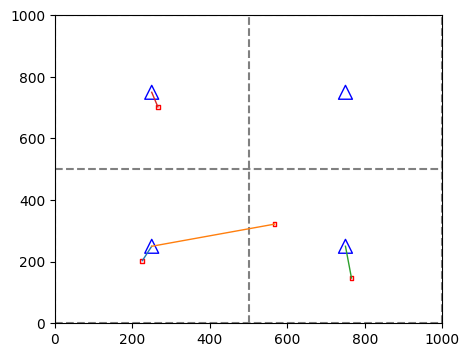

In [105]:
graphic_system(position_AP, position_UE, associate_ap)

In [106]:
pmax, pmin = 1, 1e-3
target_sinr = 1
k0 = 1e-17*1e-3
bandwidth, orthogonal_channels = 100e6, 1
noise_power = k0*(bandwidth/orthogonal_channels)

In [108]:
print("No power control - Noise-limited scenario")

power=pmax*np.ones(len(position_UE))
sum_capacity = 0
for index_ue in range(len(position_UE)): 
    sinr = calculate_sinr(gain=gain, power=power, index_ue=index_ue, index_ap=associate_ap[index_ue], noise_power=noise_power)
    
    capacity = (bandwidth/orthogonal_channels)*np.log2(1 + sinr)
    print(f"\nSINR for UE {index_ue}:  {sinr}")
    print(f"Channel Capacity for UE {index_ue}: {capacity/1e6} Mbps")
    
    sum_capacity += capacity
    
print(f"\n\nSum Capacity: {sum_capacity/1e6} Mbps")
print(f"Energy Efficiency: {sum_capacity/sum(power)} bits/J")

No power control - Noise-limited scenario

SINR for UE 0:  4.572799020031983
Channel Capacity for UE 0: 247.84021243416223 Mbps

SINR for UE 1:  0.007706370687002662
Channel Capacity for UE 1: 1.1075322106307737 Mbps

SINR for UE 2:  0.804201840229344
Channel Capacity for UE 2: 85.13607452501964 Mbps

SINR for UE 3:  0.009158221433112264
Channel Capacity for UE 3: 1.3152385922594252 Mbps


Sum Capacity: 335.399057762072 Mbps
Energy Efficiency: 83849764.440518 bits/J


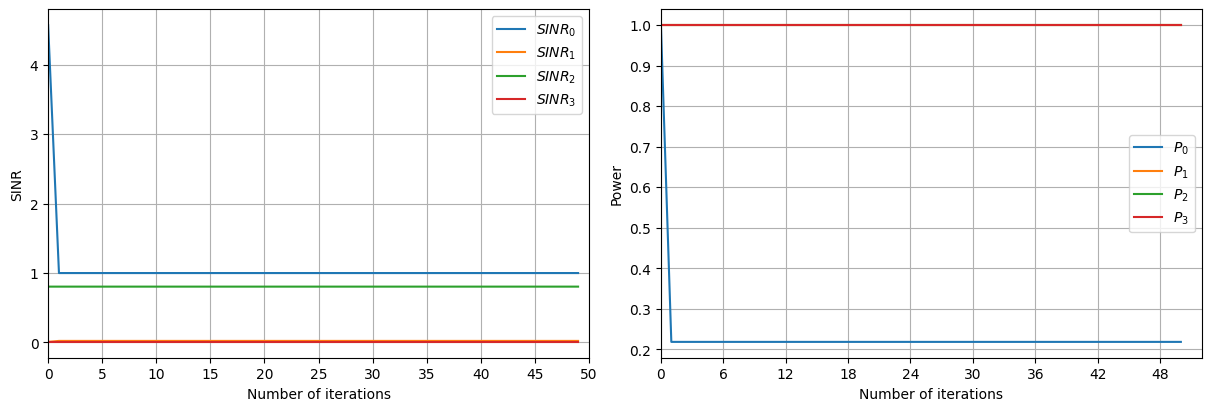

In [109]:
power=[pmax]*len(position_UE)
sinr, power = power_control_dpc(gain=gain, power=power, associate_ap=associate_ap, noise_power=noise_power)

fig, graf = plt.subplots(1, 2, figsize = (12, 4), constrained_layout=True)

for index_ue in range(len(position_UE)): 
    number_of_iterations = len(sinr[:, index_ue])
    graf[0].plot(list(range(number_of_iterations)), sinr[:, index_ue], label=f"$SINR_{index_ue}$")
graf[0].set(xlim=(0, number_of_iterations), xlabel="Number of iterations", ylabel="SINR")
graf[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
graf[0].legend()
graf[0].grid(True)

for index_ue in range(len(position_UE)): 
    number_of_iterations = len(power[:, index_ue])
    graf[1].plot(list(range(number_of_iterations)), power[:, index_ue], label=f"$P_{index_ue}$")
    

graf[1].set(xlim=(0, number_of_iterations+1), xlabel="Number of iterations", ylabel="Power")
graf[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
graf[1].legend()
graf[1].grid(True)

plt.show()

In [112]:
print("Power control - Noise-limited scenario")

power=power[-1]
sum_capacity = 0
for index_ue in range(len(position_UE)): 
    sinr = calculate_sinr(gain=gain, power=power, index_ue=index_ue, index_ap=associate_ap[index_ue], noise_power=noise_power)
    
    capacity = (bandwidth/orthogonal_channels)*np.log2(1 + sinr)
    print(f"\nSINR for UE {index_ue}:  {sinr}")
    print(f"Channel Capacity for UE {index_ue}: {capacity/1e6} Mbps")
    
    sum_capacity += capacity
    
print(f"\n\nSum Capacity: {sum_capacity/1e6} Mbps")
print(f"Energy Efficiency: {sum_capacity/sum(power)} bits/J")

Power control - Noise-limited scenario

SINR for UE 0:  1.0
Channel Capacity for UE 0: 100.0 Mbps

SINR for UE 1:  0.021772765699659257
Channel Capacity for UE 1: 3.1074387812799005 Mbps

SINR for UE 2:  0.8042113881877184
Channel Capacity for UE 2: 85.13683800698942 Mbps

SINR for UE 3:  0.009158885681791818
Channel Capacity for UE 3: 1.3153335533805117 Mbps


Sum Capacity: 189.55961034164986 Mbps
Energy Efficiency: 58893505.649336666 bits/J


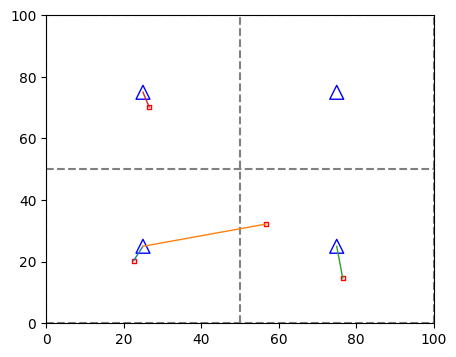

In [113]:
new_position_UE = position_UE/10
new_position_AP = position_AP/10
gain, associate_ap = calculate_gain_and_associate_ap(new_position_UE, new_position_AP, X, R)

graphic_system(new_position_AP, new_position_UE, associate_ap, size=100)

In [116]:
print("No power control - Interference-limited scenario")

power=pmax*np.ones(len(new_position_UE))
sum_capacity = 0
for index_ue in range(len(new_position_UE)): 
    sinr = calculate_sinr(gain=gain, power=power, index_ue=index_ue, index_ap=associate_ap[index_ue], noise_power=noise_power)
    
    capacity = (bandwidth/orthogonal_channels)*np.log2(1 + sinr)
    print(f"\nSINR for UE {index_ue}:  {sinr}")
    print(f"Channel Capacity for UE {index_ue}: {capacity/1e6} Mbps")
    
    sum_capacity += capacity
    
print(f"\n\nSum Capacity: {sum_capacity/1e6} Mbps")
print(f"Energy Efficiency: {(sum_capacity/sum(power))/1e6} Mbits/J")

No power control - Interference-limited scenario

SINR for UE 0:  92.68781311572234
Channel Capacity for UE 0: 654.9789489612915 Mbps

SINR for UE 1:  0.009306140546349718
Channel Capacity for UE 1: 1.3363835949180851 Mbps

SINR for UE 2:  89.21099084933063
Channel Capacity for UE 2: 649.5231309718916 Mbps

SINR for UE 3:  7.68543136752447
Channel Capacity for UE 3: 311.85975030903995 Mbps


Sum Capacity: 1617.6982138371416 Mbps
Energy Efficiency: 404.4245534592854 Mbits/J


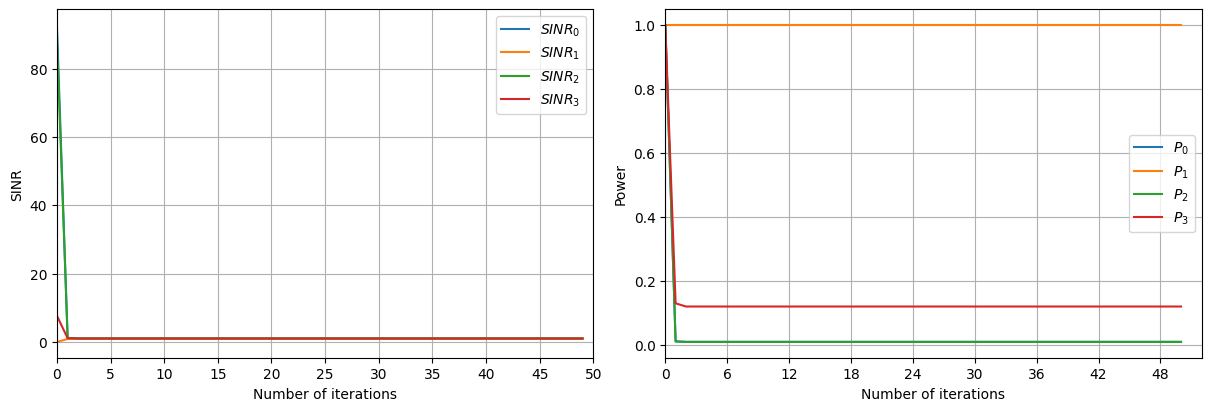

In [117]:
power=[pmax]*len(new_position_UE)
sinr, power = power_control_dpc(gain=gain, power=power, associate_ap=associate_ap, noise_power=noise_power)

fig, graf = plt.subplots(1, 2, figsize = (12, 4), constrained_layout=True)

for index_ue in range(len(new_position_UE)): 
    number_of_iterations = len(sinr[:, index_ue])
    graf[0].plot(list(range(number_of_iterations)), sinr[:, index_ue], label=f"$SINR_{index_ue}$")
    
graf[0].set(xlim=(0, number_of_iterations), xlabel="Number of iterations", ylabel="SINR")
graf[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
graf[0].legend()
graf[0].grid(True)

for index_ue in range(len(new_position_UE)): 
    number_of_iterations = len(power[:, index_ue])
    graf[1].plot(list(range(number_of_iterations)), power[:, index_ue], label=f"$P_{index_ue}$")
    

graf[1].set(xlim=(0, number_of_iterations+1), xlabel="Number of iterations", ylabel="Power")
graf[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
graf[1].legend()
graf[1].grid(True)

plt.show()

In [118]:
print("Power control - Interference-limited scenario")

power=power[-1]
sum_capacity = 0
for index_ue in range(len(position_UE)): 
    sinr = calculate_sinr(gain=gain, power=power, index_ue=index_ue, index_ap=associate_ap[index_ue], noise_power=noise_power)
    
    capacity = (bandwidth/orthogonal_channels)*np.log2(1 + sinr)
    print(f"\nSINR for UE {index_ue}:  {sinr}")
    print(f"Channel Capacity for UE {index_ue}: {capacity/1e6} Mbps")
    
    sum_capacity += capacity
    
print(f"\n\nSum Capacity: {sum_capacity/1e6} Mbps")
print(f"Energy Efficiency: {sum_capacity/sum(power)} bits/J")

Power control - Interference-limited scenario

SINR for UE 0:  1.0000000000000002
Channel Capacity for UE 0: 100.0 Mbps

SINR for UE 1:  0.962820629335211
Channel Capacity for UE 1: 97.29283393897815 Mbps

SINR for UE 2:  1.0
Channel Capacity for UE 2: 100.0 Mbps

SINR for UE 3:  1.0
Channel Capacity for UE 3: 100.0 Mbps


Sum Capacity: 397.29283393897816 Mbps
Energy Efficiency: 348804050.708093 bits/J


# Exercise 12

In [215]:
def objective_function(gain, power, associate_ap, noise_power: float = 0.01, target_sinr=0.5): 
    sinr_ue = [calculate_sinr(gain=gain, power=power, index_ue=index_ue, index_ap=associate_ap[index_ue], noise_power=noise_power) for index_ue in range(len(power))]
    return sum((target_sinr - sinr)**2 for sinr in sinr_ue)

def control_power_fdm(gain, power, associate_ap, target_sinr=1, pmax=1, pmin=1e-3, noise_power: float = 0.01, number_of_iterations:int=200):
    eta, mu = 1e-4, 1e-2
    value_sinr, value_power = [], [np.array(power)]
    for k in range(number_of_iterations): 
        value_gradient = []
        value_objective_function = objective_function(gain=gain, power=value_power[-1], associate_ap=associate_ap, noise_power=noise_power, target_sinr=target_sinr)  
             
        for index_ue in range(len(power)): 
            power_copy = (value_power[-1]).copy()
            power_copy[index_ue] += eta
            new_value_objective_function = objective_function(gain=gain, power=power_copy, associate_ap=associate_ap, noise_power=noise_power, target_sinr=target_sinr) 
            value_gradient.append((new_value_objective_function - value_objective_function)/eta)
        
        new_power = np.maximum(np.minimum(value_power[-1] - mu*np.array(value_gradient), pmax), pmin)
        value_power.append(new_power)
        
        new_sinr = [calculate_sinr(gain=gain, power=new_power, index_ue=index_ue, index_ap=associate_ap[index_ue], noise_power=noise_power) for index_ue in range(len(power))]
        value_sinr.append(new_sinr)
    
    return np.array(value_sinr), np.array(value_power)

In [216]:
sinr, power = control_power_fdm(gain=np.array([[0.1], [0.05]]), power=[1]*2, associate_ap=[0, 0], target_sinr=0.5, pmax=1, pmin=0, number_of_iterations=600)

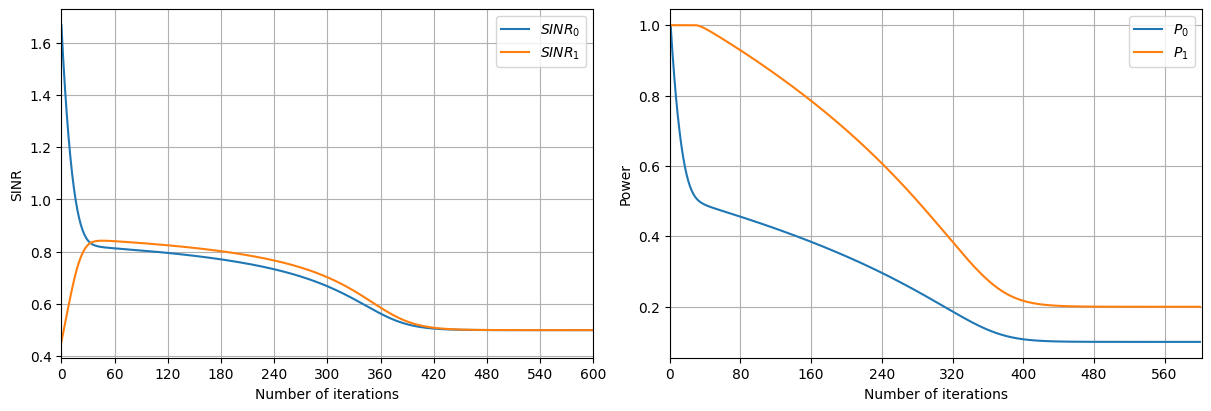

In [217]:
fig, graf = plt.subplots(1, 2, figsize = (12, 4), constrained_layout=True)

for index_ue in range(2): 
    number_of_iterations = len(sinr[:, index_ue])
    graf[0].plot(list(range(number_of_iterations)), sinr[:, index_ue], label=f"$SINR_{index_ue}$")
graf[0].set(xlim=(0, number_of_iterations), xlabel="Number of iterations", ylabel="SINR")
graf[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
graf[0].legend()
graf[0].grid(True)

for index_ue in range(2): 
    number_of_iterations = len(power[:, index_ue])
    graf[1].plot(list(range(number_of_iterations)), power[:, index_ue], label=f"$P_{index_ue}$")
    

graf[1].set(xlim=(0, number_of_iterations+1), xlabel="Number of iterations", ylabel="Power")
graf[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
graf[1].legend()
graf[1].grid(True)

plt.show()

# Exercise 13

In [252]:
def objective_function_J1(sinr_ue): 
    return min(sinr_ue)

def objective_function_J2(sinr_ue): 
    return sum(sinr_ue)

def control_power_fdm2(gain, power, associate_ap, pmax=1, pmin=1e-3, noise_power: float = 0.01, number_of_iterations:int=200, objective:str = "J1"):
    eta, mu = 1e-4, 1e-2
    value_sinr, value_power = [], [np.array(power)]
    objective = objective_function_J1 if objective == "J1" else objective_function_J2 
    
    for k in range(number_of_iterations): 
        value_gradient = []
        sinr_ue = [calculate_sinr(gain=gain, power=value_power[-1], index_ue=index_ue, index_ap=associate_ap[index_ue], noise_power=noise_power) for index_ue in range(len(power))]
        value_objective_function = objective(sinr_ue)  
             
        for index_ue in range(len(power)): 
            power_copy = (value_power[-1]).copy()
            power_copy[index_ue] += eta
            
            sinr_ue = [calculate_sinr(gain=gain, power=power_copy, index_ue=index_ue, index_ap=associate_ap[index_ue], noise_power=noise_power) for index_ue in range(len(power))]
            new_value_objective_function = objective(sinr_ue)  
            value_gradient.append((new_value_objective_function - value_objective_function)/eta)
        
        new_power = np.maximum(np.minimum(value_power[-1] + mu*np.array(value_gradient), pmax), pmin)
        value_power.append(new_power)
        
        new_sinr = [calculate_sinr(gain=gain, power=new_power, index_ue=index_ue, index_ap=associate_ap[index_ue], noise_power=noise_power) for index_ue in range(len(power))]
        value_sinr.append(new_sinr)
    
    return np.array(value_sinr), np.array(value_power)

In [253]:
position_AP = np.array([250 + 1j*750, 750 + 1j*750, 750 + 1j*250, 250 + 1j*250])
position_UE = np.array([225.83 + 1j*203.33, 566.79 + 1j*321.88, 765.51 + 1j*146.88, 265.95 + 1j*702.39])

X = np.array([[5.3434e-2, 2.8731e-1, 1.9691e-2, 7.3013e-1],
              [3.2318,     1.5770,   2.6449e-1, 5.6379],
              [6.1470e-3, 1.1424,   2.6826e-1, 4.5709],
              [1.3485e-1, 4.6690e-1, 7.8250e-1, 1.6742]
            ])

R = np.array([[1.248699, 3.248041, 0.772754, 0.708962],
              [0.498887, 0.104890, 0.647280, 0.940906],
              [0.382966, 0.682700, 1.891256, 0.327100],
              [0.065737, 0.649500, 1.981107, 1.259538]
            ])

gain, associate_ap = calculate_gain_and_associate_ap(position_UE, position_AP, X, R)

In [254]:
target_sinr = 1
k0 = 1e-17*1e-3
bandwidth, orthogonal_channels = 100e6, 1
noise_power = k0*(bandwidth/orthogonal_channels)

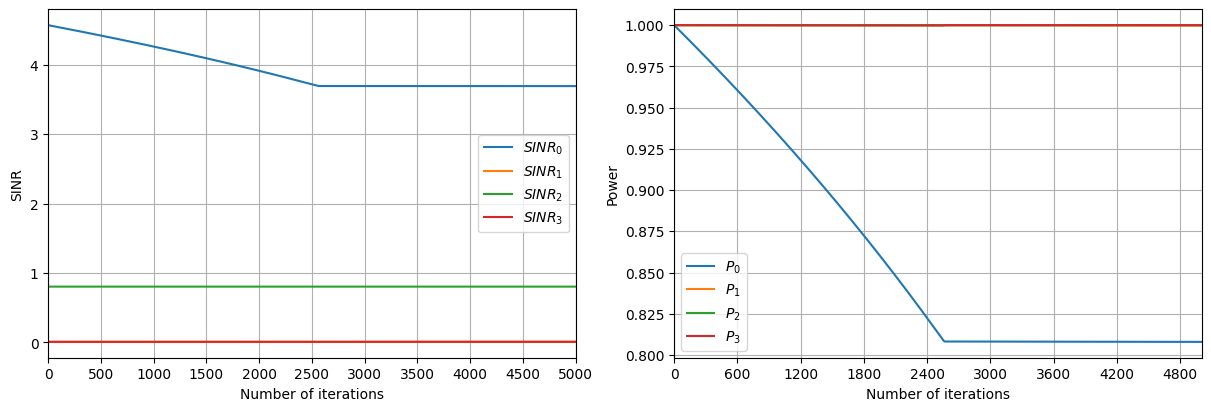

In [265]:
power=[1]*len(position_UE)
sinr, power = control_power_fdm2(gain=gain, power=power, associate_ap=associate_ap, noise_power=noise_power, number_of_iterations=5000, objective="J1")

fig, graf = plt.subplots(1, 2, figsize = (12, 4), constrained_layout=True)

for index_ue in range(len(position_UE)): 
    number_of_iterations = len(sinr[:, index_ue])
    graf[0].plot(list(range(number_of_iterations)), sinr[:, index_ue], label=f"$SINR_{index_ue}$")
graf[0].set(xlim=(0, number_of_iterations), xlabel="Number of iterations", ylabel="SINR")
graf[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
graf[0].legend()
graf[0].grid(True)

for index_ue in range(len(position_UE)): 
    number_of_iterations = len(power[:, index_ue])
    graf[1].plot(list(range(number_of_iterations)), power[:, index_ue], label=f"$P_{index_ue}$")
    

graf[1].set(xlim=(0, number_of_iterations+1), xlabel="Number of iterations", ylabel="Power")
graf[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
graf[1].legend()
graf[1].grid(True)

plt.show()

In [266]:
print("Power control FDM - Objective J1")

power=power[-1]
sum_capacity = 0
for index_ue in range(len(position_UE)): 
    sinr = calculate_sinr(gain=gain, power=power, index_ue=index_ue, index_ap=associate_ap[index_ue], noise_power=noise_power)
    
    capacity = (bandwidth/orthogonal_channels)*np.log2(1 + sinr)
    print(f"\nPower for UE {index_ue}: {power[index_ue]}")
    print(f"SINR for UE {index_ue}:  {sinr}")
    print(f"Channel Capacity for UE {index_ue}: {capacity/1e6} Mbps")
    
    sum_capacity += capacity
    
print(f"\n\nSum Capacity: {sum_capacity/1e6} Mbps")
print(f"Energy Efficiency: {sum_capacity/sum(power)} bits/J")

Power control FDM - Objective J1

Power for UE 0: 0.8079339569157762
SINR for UE 0:  3.6945548612807557
Channel Capacity for UE 0: 223.0988367704706 Mbps

Power for UE 1: 0.9997764579997176
SINR for UE 1:  0.009159286090554603
Channel Capacity for UE 1: 1.315390795865289 Mbps

Power for UE 2: 0.999974453869728
SINR for UE 2:  0.8041849590519763
Channel Capacity for UE 2: 85.13472464806753 Mbps

Power for UE 3: 1.0
SINR for UE 3:  0.009158386757081496
Channel Capacity for UE 3: 1.3152622270122196 Mbps


Sum Capacity: 310.8642144414156 Mbps
Energy Efficiency: 81641266.32165116 bits/J


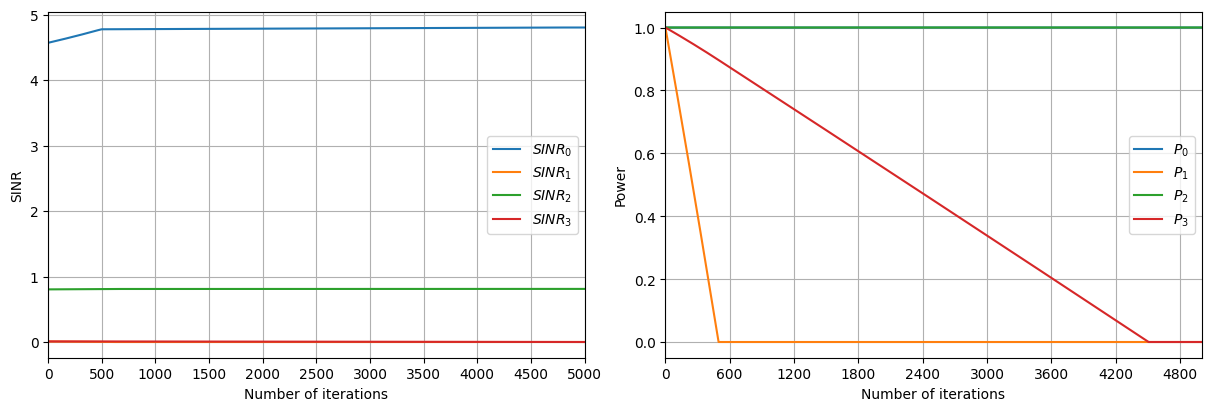

In [263]:
power=[1]*len(position_UE)
sinr, power = control_power_fdm2(gain=gain, power=power, associate_ap=associate_ap, noise_power=noise_power, number_of_iterations=5000, objective="J2")

fig, graf = plt.subplots(1, 2, figsize = (12, 4), constrained_layout=True)

for index_ue in range(len(position_UE)): 
    number_of_iterations = len(sinr[:, index_ue])
    graf[0].plot(list(range(number_of_iterations)), sinr[:, index_ue], label=f"$SINR_{index_ue}$")
graf[0].set(xlim=(0, number_of_iterations), xlabel="Number of iterations", ylabel="SINR")
graf[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
graf[0].legend()
graf[0].grid(True)

for index_ue in range(len(position_UE)): 
    number_of_iterations = len(power[:, index_ue])
    graf[1].plot(list(range(number_of_iterations)), power[:, index_ue], label=f"$P_{index_ue}$")
    

graf[1].set(xlim=(0, number_of_iterations+1), xlabel="Number of iterations", ylabel="Power")
graf[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
graf[1].legend()
graf[1].grid(True)

plt.show()

In [264]:
print("Power control FDM - Objective J2")

power=power[-1]
sum_capacity = 0
for index_ue in range(len(position_UE)): 
    sinr = calculate_sinr(gain=gain, power=power, index_ue=index_ue, index_ap=associate_ap[index_ue], noise_power=noise_power)
    
    capacity = (bandwidth/orthogonal_channels)*np.log2(1 + sinr)
    print(f"\nPower for UE {index_ue}: {power[index_ue]}")
    print(f"SINR for UE {index_ue}:  {sinr}")
    print(f"Channel Capacity for UE {index_ue}: {capacity/1e6} Mbps")
    
    sum_capacity += capacity
    
print(f"\n\nSum Capacity: {sum_capacity/1e6} Mbps")
print(f"Energy Efficiency: {sum_capacity/sum(power)} bits/J")

Power control FDM - Objective J2

Power for UE 0: 1.0
SINR for UE 0:  4.806304081133243
Channel Capacity for UE 0: 253.76201291218786 Mbps

Power for UE 1: 0.001
SINR for UE 1:  7.714752107968472e-06
Channel Capacity for UE 1: 0.0011129991675440905 Mbps

Power for UE 2: 1.0
SINR for UE 2:  0.811416469228668
Channel Capacity for UE 2: 85.711827959298 Mbps

Power for UE 3: 0.001
SINR for UE 3:  9.16736765130732e-06
Channel Capacity for UE 3: 0.0013225655226290804 Mbps


Sum Capacity: 339.476276436176 Mbps
Energy Efficiency: 169568569.6484396 bits/J


In [272]:
new_position_UE = position_UE/10
new_position_AP = position_AP/10
gain, associate_ap = calculate_gain_and_associate_ap(new_position_UE, new_position_AP, X, R)


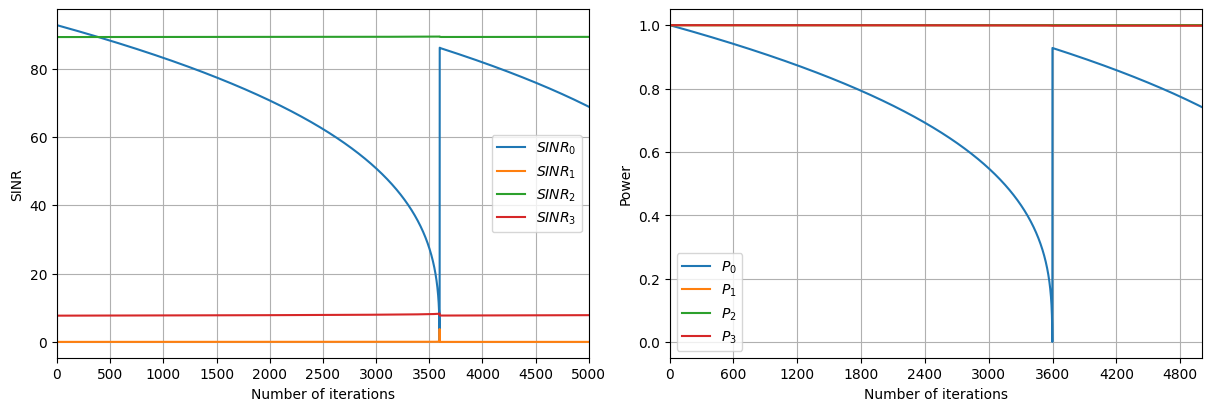

In [273]:
power=[1]*len(position_UE)
sinr, power = control_power_fdm2(gain=gain, power=power, associate_ap=associate_ap, noise_power=noise_power, number_of_iterations=5000, objective="J1")

fig, graf = plt.subplots(1, 2, figsize = (12, 4), constrained_layout=True)

for index_ue in range(len(position_UE)): 
    number_of_iterations = len(sinr[:, index_ue])
    graf[0].plot(list(range(number_of_iterations)), sinr[:, index_ue], label=f"$SINR_{index_ue}$")
graf[0].set(xlim=(0, number_of_iterations), xlabel="Number of iterations", ylabel="SINR")
graf[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
graf[0].legend()
graf[0].grid(True)

for index_ue in range(len(position_UE)): 
    number_of_iterations = len(power[:, index_ue])
    graf[1].plot(list(range(number_of_iterations)), power[:, index_ue], label=f"$P_{index_ue}$")
    

graf[1].set(xlim=(0, number_of_iterations+1), xlabel="Number of iterations", ylabel="Power")
graf[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
graf[1].legend()
graf[1].grid(True)

plt.show()

In [274]:
print("Power control FDM - Objective J1")

power=power[-1]
sum_capacity = 0
for index_ue in range(len(position_UE)): 
    sinr = calculate_sinr(gain=gain, power=power, index_ue=index_ue, index_ap=associate_ap[index_ue], noise_power=noise_power)
    
    capacity = (bandwidth/orthogonal_channels)*np.log2(1 + sinr)
    print(f"\nPower for UE {index_ue}: {power[index_ue]}")
    print(f"SINR for UE {index_ue}:  {sinr}")
    print(f"Channel Capacity for UE {index_ue}: {capacity/1e6} Mbps")
    
    sum_capacity += capacity
    
print(f"\n\nSum Capacity: {sum_capacity/1e6} Mbps")
print(f"Energy Efficiency: {sum_capacity/sum(power)} bits/J")

Power control FDM - Objective J1

Power for UE 0: 0.7423201041535438
SINR for UE 0:  68.81909250115707
Channel Capacity for UE 0: 612.5549699950631 Mbps

Power for UE 1: 1.0
SINR for UE 1:  0.012530219265134167
Channel Capacity for UE 1: 1.7964966301812006 Mbps

Power for UE 2: 0.999820082440968
SINR for UE 2:  89.26151597328008
Channel Capacity for UE 2: 649.6039104201852 Mbps

Power for UE 3: 0.9982223930309566
SINR for UE 3:  7.8289150491831645
Channel Capacity for UE 3: 314.22361616185844 Mbps


Sum Capacity: 1578.1789932072877 Mbps
Energy Efficiency: 421932088.0291008 bits/J


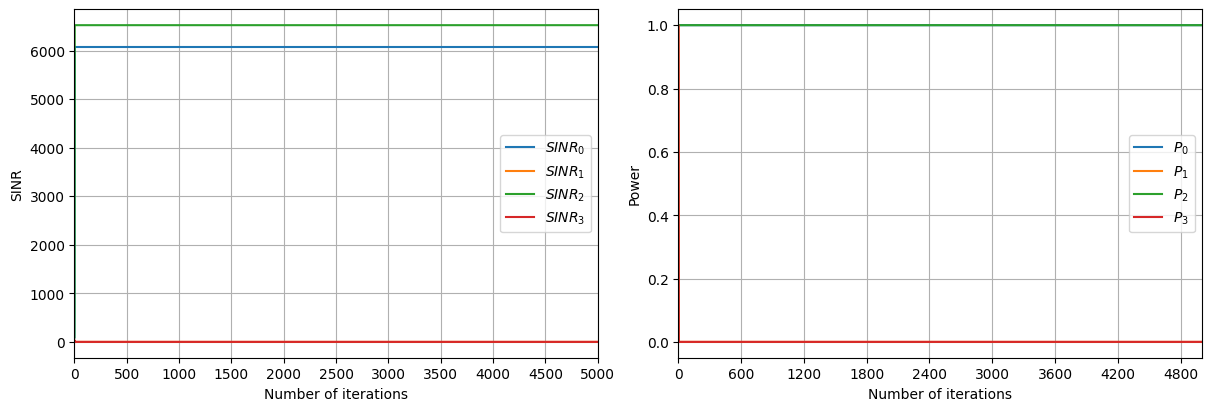

In [275]:
power=[1]*len(position_UE)
sinr, power = control_power_fdm2(gain=gain, power=power, associate_ap=associate_ap, noise_power=noise_power, number_of_iterations=5000, objective="J2")

fig, graf = plt.subplots(1, 2, figsize = (12, 4), constrained_layout=True)

for index_ue in range(len(position_UE)): 
    number_of_iterations = len(sinr[:, index_ue])
    graf[0].plot(list(range(number_of_iterations)), sinr[:, index_ue], label=f"$SINR_{index_ue}$")
graf[0].set(xlim=(0, number_of_iterations), xlabel="Number of iterations", ylabel="SINR")
graf[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
graf[0].legend()
graf[0].grid(True)

for index_ue in range(len(position_UE)): 
    number_of_iterations = len(power[:, index_ue])
    graf[1].plot(list(range(number_of_iterations)), power[:, index_ue], label=f"$P_{index_ue}$")
    

graf[1].set(xlim=(0, number_of_iterations+1), xlabel="Number of iterations", ylabel="Power")
graf[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
graf[1].legend()
graf[1].grid(True)

plt.show()

In [270]:
print("Power control FDM - Objective J2")

power=power[-1]
sum_capacity = 0
for index_ue in range(len(position_UE)): 
    sinr = calculate_sinr(gain=gain, power=power, index_ue=index_ue, index_ap=associate_ap[index_ue], noise_power=noise_power)
    
    capacity = (bandwidth/orthogonal_channels)*np.log2(1 + sinr)
    print(f"\nPower for UE {index_ue}: {power[index_ue]}")
    print(f"SINR for UE {index_ue}:  {sinr}")
    print(f"Channel Capacity for UE {index_ue}: {capacity/1e6} Mbps")
    
    sum_capacity += capacity
    
print(f"\n\nSum Capacity: {sum_capacity/1e6} Mbps")
print(f"Energy Efficiency: {sum_capacity/sum(power)} bits/J")

Power control FDM - Objective J2

Power for UE 0: 1.0
SINR for UE 0:  6077.515438666492
Channel Capacity for UE 0: 1256.9503300634306 Mbps

Power for UE 1: 0.001
SINR for UE 1:  9.31836572295349e-06
Channel Capacity for UE 1: 0.0013443497382209005 Mbps

Power for UE 2: 1.0
SINR for UE 2:  6527.389259270609
Channel Capacity for UE 2: 1267.2511366125393 Mbps

Power for UE 3: 0.001
SINR for UE 3:  0.04722167569038333
Channel Capacity for UE 3: 6.656686401476527 Mbps


Sum Capacity: 2530.8594974271846 Mbps
Energy Efficiency: 1264165583.130462 bits/J
